In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.define import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
latt_size = (16, 16, 16, 16)
# latt_size = (16, 16, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 16, 16, 32)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=24)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
# clover_term = torch.zeros_like(clover_term) # just for test, just wilson

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True
tol = 1e-6
max_iter = 1000

Using device: cuda


In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.159793231010612e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover_term, tol=tol, max_iter=max_iter, verbose=verbose)
mg.init()

self.dof_list:[12, 24, 24, 24, 24]
Building grid list:
  Level 0: 16x16x16x16
  Level 1: 8x8x8x8
  Level 2: 4x4x4x4
  Level 3: 2x2x2x2
self.grid_list:[[16, 16, 16, 16], [8, 8, 8, 8], [4, 4, 4, 4], [2, 2, 2, 2]]
Norm of b:995.3552942777527
Norm of r:1406.9523673891347
Norm of x0:886.7027165587419
BICGSTAB-Iteration 0: Residual = 2.423532e+02, Time = 0.049433 s
BICGSTAB-Iteration 1: Residual = 7.992467e+01, Time = 0.048609 s
BICGSTAB-Iteration 2: Residual = 1.574924e+02, Time = 0.048735 s
BICGSTAB-Iteration 3: Residual = 2.681063e+01, Time = 0.048604 s
BICGSTAB-Iteration 4: Residual = 2.086307e+01, Time = 0.048671 s
BICGSTAB-Iteration 5: Residual = 1.178969e+01, Time = 0.048589 s
BICGSTAB-Iteration 6: Residual = 7.198665e+00, Time = 0.048709 s
BICGSTAB-Iteration 7: Residual = 1.260060e+01, Time = 0.048800 s
BICGSTAB-Iteration 8: Residual = 1.048705e+01, Time = 0.048594 s
BICGSTAB-Iteration 9: Residual = 6.744843e+00, Time = 0.048610 s
BICGSTAB-Iteration 10: Residual = 5.790636e+00, Time 

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 2.29 ms, sys: 64 μs, total: 2.35 ms
Wall time: 2.23 ms
CPU times: user 1.06 ms, sys: 30 μs, total: 1.09 ms
Wall time: 1.02 ms
886.8100134752651
42.71924944969692
995.0339592804646
995.0339592804646
1.7433398816555915e-16
CPU times: user 230 ms, sys: 105 μs, total: 230 ms
Wall time: 229 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 2.95 ms, sys: 81 μs, total: 3.03 ms
Wall time: 2.57 ms
CPU times: user 1.07 ms, sys: 30 μs, total: 1.1 ms
Wall time: 1.03 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000+1.0861e-16j, 1.0000+2.2107e-16j, 1.0000-1.7473e-16j,
        1.0000-3.5447e-16j, 1.0000+5.3059e-17j, 1.0000+7.0862e-18j,
        1.0000+1.5371e-16j, 1.0000+4.5575e-16j, 1.0000-2.1162e-16j,
        1.0000-2.5768e-16j, 1.0000-1.8215e-16j, 1.0000-2.9745e-16j,
        1.0000-8.1363e-17j, 1.0000-3.8012e-16j, 1.0000-2.9769e-16j,
        1.0000+1.3257e-16j, 1.0000+1.4584e-17j, 1.0000+2.6515e-16j,
        1.0000-2.8315e-16j, 1.0000+5.8799e-17j, 1.0000+6.7695e-17j,
        1.0000+1.4121e-15j, 1.0000-1.3366e-16j, 1.0000+6.1211e-17j,
        1.0000-7.0328e-17j, 1.0000+5.1557e-16j, 1.0000-2.7555e-16j,
        1.0000+1.1461e-16j, 1.0000-8.6589e-17j, 1.0000+7.4400e-17j,
        

In [8]:
_x = inverse.bicgstab(b=b, matvec=_matvec, tol=tol,
                      max_iter=max_iter, verbose=verbose)

Norm of b:886.9942300110736
Norm of r:1332.8023571545284
Norm of x0:886.406153412973
BICGSTAB-Iteration 0: Residual = 2.886100e+02, Time = 0.048659 s
BICGSTAB-Iteration 1: Residual = 1.267457e+02, Time = 0.048763 s
BICGSTAB-Iteration 2: Residual = 1.249156e+02, Time = 0.048699 s
BICGSTAB-Iteration 3: Residual = 8.380471e+01, Time = 0.048683 s
BICGSTAB-Iteration 4: Residual = 5.304314e+01, Time = 0.049037 s
BICGSTAB-Iteration 5: Residual = 1.539106e+02, Time = 0.049015 s
BICGSTAB-Iteration 6: Residual = 2.971276e+01, Time = 0.048729 s
BICGSTAB-Iteration 7: Residual = 2.334158e+01, Time = 0.048675 s
BICGSTAB-Iteration 8: Residual = 3.822538e+01, Time = 0.048773 s
BICGSTAB-Iteration 9: Residual = 3.087192e+01, Time = 0.048824 s
BICGSTAB-Iteration 10: Residual = 1.816187e+01, Time = 0.048876 s
BICGSTAB-Iteration 11: Residual = 1.629683e+01, Time = 0.048785 s
BICGSTAB-Iteration 12: Residual = 1.683456e+01, Time = 0.048726 s
BICGSTAB-Iteration 13: Residual = 1.454916e+01, Time = 0.048842 s
B

MG-0:Norm of b:886.9942300110736
MG-0:Norm of r:886.9942300110736
MG-0:Norm of x0:0.0
B-MG-0-BICGSTAB-Iteration 0: Residual = 2.286581e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:133.3296339478921
MG-1:Norm of r:133.3296339478921
MG-1:Norm of x0:0.0
B-MG-1-BICGSTAB-Iteration 0: Residual = 4.362090e+01
F-MG-1-BICGSTAB-Iteration 0: Residual = 4.362090e+01, Time = 0.011616 s
B-MG-1-BICGSTAB-Iteration 1: Residual = 2.093899e+01
F-MG-1-BICGSTAB-Iteration 1: Residual = 2.093899e+01, Time = 0.011593 s
B-MG-1-BICGSTAB-Iteration 2: Residual = 1.368074e+01
F-MG-1-BICGSTAB-Iteration 2: Residual = 1.368074e+01, Time = 0.011554 s
B-MG-1-BICGSTAB-Iteration 3: Residual = 2.433537e+01
F-MG-1-BICGSTAB-Iteration 3: Residual = 2.433537e+01, Time = 0.011491 s
B-MG-1-BICGSTAB-Iteration 4: Residual = 1.540155e+01
F-MG-1-BICGSTAB-Iteration 4: Residual = 1.540155e+01, Time = 0.011464 s
B-MG-1-BICGSTAB-Iteration 5: Residual = 6.873

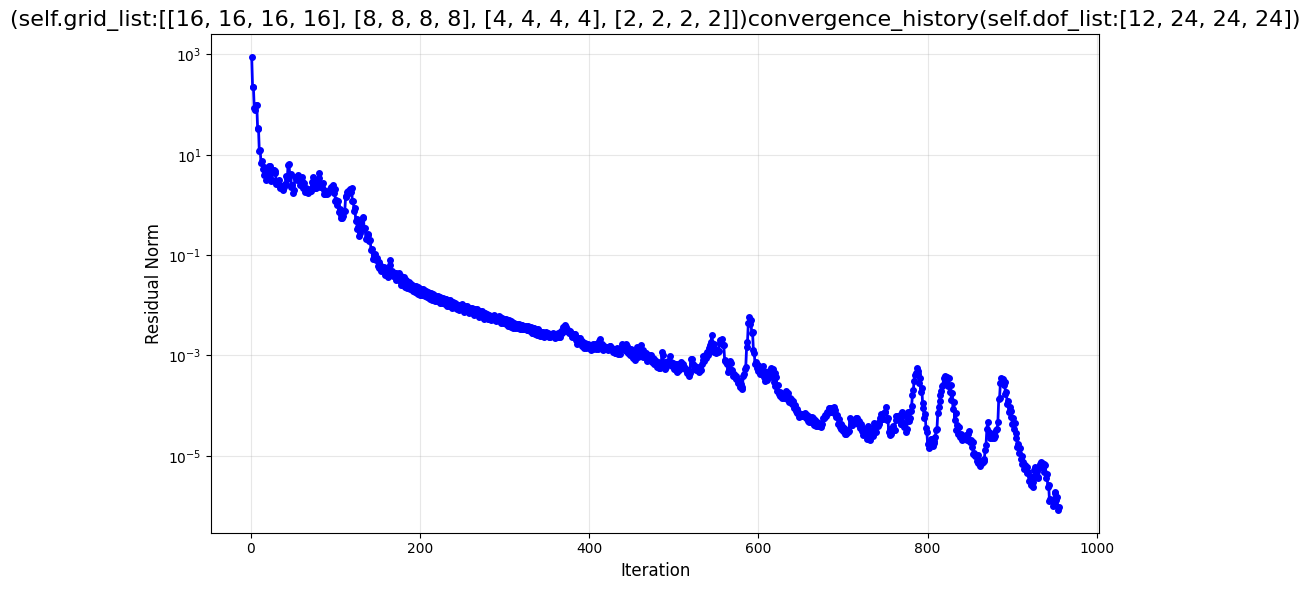

In [ ]:
mg.num_levels = 3
x = mg.solve()
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([ 3.5382e-10-1.7755e-10j,  5.0270e-10-3.4716e-10j,
         3.3960e-10-1.9821e-10j,  6.2605e-10-1.4628e-10j,
         3.4677e-10+1.4278e-10j,  8.3746e-10-4.8922e-10j,
         6.1272e-10+3.0114e-10j,  1.9301e-10-1.6234e-10j,
         5.3251e-10-1.4276e-10j,  5.7019e-10+2.7420e-10j,
         6.9866e-10+4.1983e-10j,  9.6212e-10+8.6454e-10j,
        -2.3794e-10+1.0908e-10j,  7.8354e-11-2.2199e-10j,
         7.5017e-10+3.6437e-10j,  1.2534e-09-6.3025e-10j,
         7.9017e-10-4.8605e-10j,  7.3098e-10+6.2057e-10j,
         2.5054e-10-5.0223e-10j,  1.8582e-10-2.9084e-10j,
         5.3293e-10-3.6772e-10j,  2.0314e-10+5.6837e-11j,
         4.7355e-10-4.6681e-10j,  4.1519e-10-3.9803e-10j,
         5.5829e-10-1.2475e-10j,  2.3990e-10+3.2691e-10j,
         3.5322e-10+2.6899e-10j,  4.5959e-10+6.2860e-10j,
        -1.8515e-10+1.9184e-10j,  5.2602e-11+2.6930e-10j,
         1.0239e-09-1.9347e-10j,  2.0928e-10+1.5731e-10j,
        -6.3051e-11-3.3598e-10j,  1.2734e-10-2.3018e-10j,
         1.564

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

7.24527700309746e-08


In [13]:
mg.num_levels

2

In [14]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0025+4.4545e-03j, 0.0023+2.8657e-03j, 0.0016+1.6312e-03j,
        0.0017-8.2394e-05j, 0.0036-1.4098e-05j, 0.0054-1.1499e-04j,
        0.0056-1.4688e-04j, 0.0087+9.9428e-04j, 0.0102-3.6258e-04j,
        0.0142+2.1335e-03j], device='cuda:0', dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0094+0.0052j, 0.0092+0.0085j, 0.0076+0.0090j, 0.0066+0.0127j,
        0.0060+0.0122j, 0.0047+0.0149j, 0.0068+0.0155j, 0.0040+0.0164j,
        0.0057+0.0142j, 0.0070+0.0140j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0129-0.0106j, -0.0162-0.0076j, -0.0143-0.0119j, -0.0172-0.0144j,
        -0.0145-0.0091j, -0.0135-0.0192j, -0.0142-0.0123j, -0.0036-0.0142j,
        -0.0063-0.0118j, -0.0060-0.0090j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0061+0.0008j, 0.0073+0.0009j, 0.0057

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([ 0.0284-6.0525e-03j, -0.0019-5.7686e-03j, -0.0178+2.2601e-02j,
        -0.0170+2.2002e-03j,  0.0027-3.1349e-03j,  0.0059-3.9816e-03j,
        -0.0123+1.8726e-02j,  0.0082-3.9065e-03j, -0.0183+1.1760e-02j,
         0.0043+4.2612e-03j,  0.0062-1.6284e-02j, -0.0024-5.7841e-03j,
         0.0086-5.3486e-03j, -0.0037-1.3313e-02j,  0.0033-1.5541e-02j,
         0.0077-4.8642e-03j,  0.0027-1.2816e-02j,  0.0004+6.5064e-03j,
        -0.0016+8.8243e-03j, -0.0059+2.1515e-02j,  0.0127-9.1273e-03j,
         0.0026+8.1515e-04j, -0.0106-8.4660e-03j, -0.0061+1.0956e-03j,
         0.0011-4.0502e-03j,  0.0016-6.2687e-03j,  0.0138-2.7308e-02j,
         0.0001-3.7182e-03j, -0.0023+1.4997e-03j,  0.0028-7.3309e-03j,
         0.0040-1.0904e-02j,  0.0101+7.8339e-03j, -0.0132-2.1866e-02j,
         0.0042-1.2421e-02j,  0.0095-1.1360e-02j, -0.0105+1.2526e-02j,
         0.0004+5.5926e-03j,  0.0099-2.3943e-02j,  0.0060-6.1089e-02j,
        -0.0092-3.9249e-03j,  0.0106-1.5719e-04j,  0.0150-1.0140e-02j,
      

In [16]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(996.2699, device='cuda:0', dtype=torch.float64)
tensor([-1.5224+0.1974j, -0.0235+0.7412j, -0.2283-0.8739j, -0.6141+1.5909j,
         0.2004-0.0669j, -0.0872-0.7554j,  0.3914-0.2550j,  0.3031-0.5108j,
        -0.5740-0.2022j, -0.3499-0.3044j, -1.1797-0.5178j,  1.7831-0.8968j,
        -1.6398+0.1959j,  0.8352+0.4443j, -0.5559-0.5721j,  1.0357+0.1604j,
         1.0953-0.1909j, -0.7026+1.3594j,  1.0967-0.7519j,  1.0576+0.6987j],
       device='cuda:0', dtype=torch.complex128)
Norm of b:996.2699406824439
Norm of r:1408.919902222698
Norm of x0:887.5483329882467
BICGSTAB-Iteration 0: Residual = 2.426724e+02, Time = 0.048655 s
BICGSTAB-Iteration 1: Residual = 7.995931e+01, Time = 0.048746 s
BICGSTAB-Iteration 2: Residual = 1.575293e+02, Time = 0.048922 s
BICGSTAB-Iteration 3: Residual = 2.684975e+01, Time = 0.048936 s
BICGSTAB-Iteration 4: Residual = 2.250957e+01, Time = 0.048741 s
BICGSTAB-Iteration 5: Residual = 1.183274e+01, Time = 0.048930 s
BICGSTAB-Iteration 6: Residual = 8.125699

In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:887.8587303968645
Norm of r:1334.9503405967264
Norm of x0:887.970189110443
BICGSTAB-Iteration 0: Residual = 2.887691e+02, Time = 0.048755 s
BICGSTAB-Iteration 1: Residual = 1.304258e+02, Time = 0.048894 s
BICGSTAB-Iteration 2: Residual = 1.243111e+02, Time = 0.048741 s
BICGSTAB-Iteration 3: Residual = 8.372750e+01, Time = 0.048901 s
BICGSTAB-Iteration 4: Residual = 5.268672e+01, Time = 0.048726 s
BICGSTAB-Iteration 5: Residual = 5.008311e+01, Time = 0.048954 s
BICGSTAB-Iteration 6: Residual = 3.172444e+01, Time = 0.048749 s
BICGSTAB-Iteration 7: Residual = 2.757638e+01, Time = 0.048748 s
BICGSTAB-Iteration 8: Residual = 2.154854e+01, Time = 0.048874 s
BICGSTAB-Iteration 9: Residual = 3.890325e+01, Time = 0.048789 s
BICGSTAB-Iteration 10: Residual = 2.476241e+01, Time = 0.048938 s
BICGSTAB-Iteration 11: Residual = 2.275196e+01, Time = 0.048759 s
BICGSTAB-Iteration 12: Residual = 3.357638e+01, Time = 0.048841 s
BICGSTAB-Iteration 13: Residual = 8.319298e+01, Time = 0.048831 s
B

In [18]:
_null_vec.flatten()[:100]

tensor([0.0008+0.0014j, 0.0010+0.0012j, 0.0008+0.0014j, 0.0010+0.0011j,
        0.0011+0.0011j, 0.0010+0.0012j, 0.0009+0.0012j, 0.0009+0.0011j,
        0.0008+0.0013j, 0.0010+0.0012j, 0.0009+0.0011j, 0.0009+0.0011j,
        0.0011+0.0011j, 0.0012+0.0011j, 0.0011+0.0012j, 0.0009+0.0010j,
        0.0007+0.0013j, 0.0009+0.0011j, 0.0010+0.0011j, 0.0011+0.0011j,
        0.0010+0.0011j, 0.0010+0.0012j, 0.0010+0.0012j, 0.0010+0.0012j,
        0.0009+0.0013j, 0.0010+0.0012j, 0.0010+0.0012j, 0.0009+0.0012j,
        0.0010+0.0012j, 0.0010+0.0013j, 0.0010+0.0012j, 0.0011+0.0011j,
        0.0009+0.0013j, 0.0007+0.0012j, 0.0010+0.0012j, 0.0011+0.0013j,
        0.0012+0.0011j, 0.0011+0.0010j, 0.0010+0.0012j, 0.0010+0.0014j,
        0.0010+0.0014j, 0.0011+0.0013j, 0.0010+0.0014j, 0.0010+0.0013j,
        0.0011+0.0012j, 0.0009+0.0012j, 0.0009+0.0013j, 0.0009+0.0013j,
        0.0011+0.0012j, 0.0012+0.0012j, 0.0010+0.0012j, 0.0010+0.0012j,
        0.0010+0.0012j, 0.0011+0.0011j, 0.0009+0.0012j, 0.0008+0

In [19]:
mg.lonv_list[1].flatten()[:100]

tensor([-0.0020+4.8936e-03j,  0.0027-1.8295e-03j, -0.0021-3.9173e-03j,
        -0.0019+1.4046e-03j, -0.0060+7.1057e-03j,  0.0011-8.2737e-03j,
        -0.0060-4.8806e-05j, -0.0030+4.0190e-03j, -0.0029-6.6726e-03j,
        -0.0014+5.2929e-03j, -0.0088+1.0949e-02j, -0.0020+9.5830e-03j,
        -0.0057+2.6523e-03j, -0.0019+9.0091e-04j, -0.0047+4.9175e-05j,
        -0.0039-5.5607e-03j, -0.0030-1.4425e-02j,  0.0018+2.1626e-03j,
        -0.0063-2.8080e-03j, -0.0035+1.2376e-03j, -0.0045+5.7786e-03j,
         0.0026-1.9916e-03j, -0.0046-2.1668e-02j,  0.0083-1.8500e-03j,
        -0.0013-3.6924e-03j,  0.0031+1.0529e-02j, -0.0040-7.3112e-03j,
         0.0003+6.8893e-03j,  0.0041-2.4692e-03j,  0.0094+8.3991e-03j,
        -0.0143-2.2887e-02j, -0.0043-9.0576e-03j, -0.0046-5.3580e-03j,
        -0.0005+3.4687e-03j, -0.0079-6.9265e-03j, -0.0006+1.3916e-03j,
        -0.0039+4.1634e-03j, -0.0116-2.8880e-03j, -0.0087-6.8305e-03j,
        -0.0051-2.6572e-03j,  0.0098-4.8717e-03j, -0.0077-4.4628e-03j,
      